In [1]:
import os
import numpy as np
import cv2
import random
import pandas as pd
from tqdm import tqdm
import keras.backend as K
import matplotlib.pyplot as plt
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback

from keras import regularizers
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.applications.densenet import DenseNet169, DenseNet121, preprocess_input
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Lambda
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K
from sklearn.manifold import TSNE

import datetime

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def listdir_nohidden(path):
    '''
    Utility function to find the list of files in a directory excluding the hidden files.
    Args:
        path: contains the path of the directory containing the images

    '''
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [3]:
def create_images_metadata_csv(category,study_types):
    '''
    This function creates a csv file containing the path of images, label.
    Args:
        category: train or valid, depending on which csv is needed
        study_types: the type of the body part in MURA Dataset, eg:  XR_SHOULDER
    '''
    image_data = {}
    study_label = {'positive': 1, 'negative': 0}
    #study_types = ['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']
    #study_types = ['XR_ELBOW']
    i = 0
    image_data[category] = pd.DataFrame(columns=['Path','Count', 'Label'])
    for study_type in study_types: # Iterate throught every study types
        DATA_DIR = '/kaggle/input/dataset/MURA-v1.1/%s/%s/' % (category, study_type)
        patients = []
        if os.path.exists(DATA_DIR):
            patients = list(os.walk(DATA_DIR))
            if len(patients) > 0:
                patients = patients[0][1]  # list of patient folder names
                # Rest of your code
            else:
                print("No subdirectories found in DATA_DIR.")
                
        else:
            print("DATA_DIR does not exist.")
            print(DATA_DIR)
        # patients = list(os.walk(DATA_DIR))[0][1]  # list of patient folder names
        for patient in tqdm(patients):  # for each patient folder
            for study in os.listdir(DATA_DIR + patient):  # for each study in that patient folder
                if(study != '.DS_Store'):
                    label = study_label[study.split('_')[1]]  # get label 0 or 1
                    path = DATA_DIR + patient + '/' + study + '/'  # path to this study
                    for j in range(len(list(listdir_nohidden(path)))):
                        image_path = path + 'image%s.png' % (j + 1)
                        image_data[category].loc[i] = [image_path,1, label]  # add new row
                        i += 1
    image_data[category].to_csv(category+"_image_data.csv",index = None, header=False)

In [4]:
def getImageLabels(dataframe):
  '''
  This function is to get the labels of the images from the dataframe
  Args:
      dataframe: pandas dataframe containing the labels of the images

  '''
  labels = []
  for i, data in tqdm(dataframe.iterrows()):
#        img = cv2.imread(data['Path'])
#         #random rotation
#         angle = random.randint(-30,30)
#         M = cv2.getRotationMatrix2D((img_width/2,img_height/2),angle,1)
#         img = cv2.warpAffine(img,M,(img_width,img_height))
      #resize
#        img = cv2.resize(img,(img_width,img_height))    
#        img = img[...,::-1].astype(np.float32)
#        images.append(img)
      labels.append(data['Label'])
#    images = np.asarray(images).astype('float32') 
  #normalization
#    mean = np.mean(images[:, :, :])
#    std = np.std(images[:, :, :])
#    images[:, :, :] = (images[:, :, :] - mean) / std
  labels = np.asarray(labels)
  return labels

In [5]:
# import cv2
# import numpy as np
# from tqdm import tqdm

# def apply_clahe(image):
#     # Convert the image to LAB color space
#     lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

#     # Split the LAB image into L, A, and B channels
#     l, a, b = cv2.split(lab)

#     # Apply CLAHE to the L channel
#     clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
#     cl = clahe.apply(l)

#     # Merge the processed L channel with the original A and B channels
#     processed_image = cv2.merge((cl, a, b))

#     # Convert the image back to BGR color space
#     processed_image = cv2.cvtColor(processed_image, cv2.COLOR_LAB2BGR)

#     return processed_image

# def getImage(dataframe, size):
#     '''
#     Function to process the images
#     Args:
#         dataframe: contains the path to the images in the directory
#         size: contains the value to which the shape of the image will resized
#     '''
#     Images = []
#     normal_imgs = []
#     abnormal_imgs = []
#     for i, data in tqdm(dataframe.iterrows()):
#         image = cv2.imread(data['Path'])#cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image,(size,size))
#         #image = randome_rotation_flip(image,size)
#         image = apply_clahe(image)
#         Images.append(image)
# #         if(data['Label'] == 1):
# #             abnormal_imgs.append(image)
# #         elif(data['Label'] == 0):
# #             normal_imgs.append(image)
# #       try:
# #         image = cv2.imread(data['Path'])#cv2.IMREAD_GRAYSCALE)
# #         image = cv2.resize(image,(size,size))
# #         #image = randome_rotation_flip(image,size)
# #         Images.append(image)

# #       except Exception as e:
# #         print(str(e))


#     Images = np.asarray(Images).astype('float32')

#     mean = np.mean(Images)			#normalization
#     std = np.std(Images)
#     Images = (Images - mean) / std
    
# #     normal_imgs = np.asarray(normal_imgs).astype('float32')

# #     mean = np.mean(normal_imgs)			#normalization
# #     std = np.std(normal_imgs)
# #     normal_imgs = (normal_imgs - mean) / std
    
# #     abnormal_imgs = np.asarray(abnormal_imgs).astype('float32')

# #     mean = np.mean(abnormal_imgs)			#normalization
# #     std = np.std(abnormal_imgs)
# #     abnormal_imgs = (abnormal_imgs - mean) / std
    
#     #if K.image_data_format() == "channels_first":
#     #  Images = np.expand_dims(Images,axis=3)		   #Extended dimension 1
#     #if K.image_data_format() == "channels_last":
#     #  Images = np.expand_dims(Images,axis=3)             #Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1) 
# #     return Images, abnormal_imgs, normal_imgs
#     return Images


In [6]:
def getImage(dataframe, size):
    '''
    Function to process the images
    Args:
        dataframe: contains the path to the images in the directory
        size: contains the value to which the shape of the image will resized
    '''
    Images = []
    for i, data in tqdm(dataframe.iterrows()):
        image = cv2.imread(data['Path'])#cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image,(size,size))
        #image = randome_rotation_flip(image,size)
        Images.append(image)
#       try:
#         image = cv2.imread(data['Path'])#cv2.IMREAD_GRAYSCALE)
#         image = cv2.resize(image,(size,size))
#         #image = randome_rotation_flip(image,size)
#         Images.append(image)

#       except Exception as e:
#         print(str(e))


    Images = np.asarray(Images).astype('float32')

    mean = np.mean(Images)			#normalization
    std = np.std(Images)
    Images = (Images - mean) / std
    
    #if K.image_data_format() == "channels_first":
    #  Images = np.expand_dims(Images,axis=3)		   #Extended dimension 1
    #if K.image_data_format() == "channels_last":
    #  Images = np.expand_dims(Images,axis=3)             #Extended dimension 3(usebackend tensorflow:aixs=3; theano:axixs=1) 
    return Images


In [7]:
###################
# Data processing #
###################
from keras.preprocessing.image import ImageDataGenerator

img_width, img_height = 224, 224
#Keras ImageDataGenerator to load, transform the images of the dataset
#BASE_DATA_DIR = 'data/'
IMG_DATA_DIR = '/kaggle/input/dataset/MURA-v1.1'
train_data_dir = IMG_DATA_DIR + '/train/XR_FINGER'
valid_data_dir = IMG_DATA_DIR + '/valid/XR_FINGER'


train_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True

)
study_types = ['XR_FINGER']

#TRAIN DATA
create_images_metadata_csv('train',study_types)
#VALID DATA
create_images_metadata_csv('valid',study_types)

100%|██████████| 166/166 [00:00<00:00, 216.95it/s]


In [8]:
valid_image_df = pd.read_csv('valid_image_data.csv', names=['Path','Count', 'Label'])
train_image_df = pd.read_csv('train_image_data.csv', names=['Path', 'Count','Label'])

dd={}

dd['train'] = train_image_df
dd['valid'] = valid_image_df

In [9]:
#train_images contains all training images of finger which is 5106
#abnormal_train_images contain abnormal class images in training set

# train_images, abnormal_train_images, normal_train_images = getImage(train_image_df, size = 224)
train_images = getImage(train_image_df, size = 224)

5106it [00:43, 116.42it/s]


In [10]:
#labels of training set

train_image_labels = getImageLabels(train_image_df)
train_image_labels = np.array(train_image_labels)                 #converted for below network

5106it [00:00, 16871.41it/s]


In [11]:
#valid_images contains all training images of finger which is 461
#abnormal_valid_images contain abnormal class images in validation set

# valid_images, abnormal_valid_images, normal_valid_images = getImage(valid_image_df, size = 224)
valid_images = getImage(valid_image_df, size = 224)

461it [00:03, 122.98it/s]


In [12]:
#labels of validation set

valid_image_labels = getImageLabels(valid_image_df)
valid_image_labels = np.array(valid_image_labels)            #converted for below network

461it [00:00, 16085.77it/s]


In [13]:
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = valid_image_labels; X = valid_images
    else:
        y = train_image_labels; X = train_images
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]
    
def get_triplet(test=False):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(0, 2)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(0, 2)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

def generate_triplets(test=False):
    """Generate an un-ending stream (ie a generator) of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)
            
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size)
        yield [A, P, N], label


In [14]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def embedding_model():
  # Simple convolutional model 
  # used for the embedding model.
  model = Sequential()
  model.add(Convolution2D(32, (3, 3), activation='relu',
                        input_shape=(224,224,3)))
  model.add(Convolution2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(10))
  return model

def complete_model(base_model):
    # Create the complete model with three
    # embedding models and minimize the loss 
    # between their output embeddings
    input_1 = Input((imsize, imsize, 3))
    input_2 = Input((imsize, imsize, 3))
    input_3 = Input((imsize, imsize, 3))
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
#     model.compile(loss=identity_loss, optimizer=Adam(LR), metrics=["accuracy"])
    model.compile(loss=identity_loss, optimizer=Adam(LR))
    return model
  

In [15]:
# Define aspects of the model and create instances of both the 
# test and train batch generators and the complete model.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model


imsize = 224
batch_size = 16
embedding_dim = 2 
LR = 0.0001
EPOCHS = 5
alpha = 0.2 

train_generator = generate_triplets()
test_generator = generate_triplets(test=True)
batch = next(train_generator)

#base_model = embedding_model()

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)

# Create the custom head for ResNet50 and attach it to the base model
base_model = Model(inputs=base_model.input, outputs=x)

model = complete_model(base_model)
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                           

In [16]:
#densenet169-2
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_990/2763086789.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 66s - loss: 0.3586 - val_loss: 0.2067 - 66s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 0.2296 - val_loss: 0.1989 - 11s/epoch - 548ms/step
Epoch 3/50
20/20 - 11s - loss: 0.2128 - val_loss: 0.2029 - 11s/epoch - 549ms/step
Epoch 4/50
20/20 - 11s - loss: 0.2065 - val_loss: 0.2184 - 11s/epoch - 548ms/step
Epoch 5/50
20/20 - 11s - loss: 0.2157 - val_loss: 0.2038 - 11s/epoch - 548ms/step
Epoch 6/50
20/20 - 11s - loss: 0.2040 - val_loss: 0.2045 - 11s/epoch - 547ms/step
Epoch 7/50
20/20 - 11s - loss: 0.2029 - val_loss: 0.2036 - 11s/epoch - 548ms/step
Epoch 8/50
20/20 - 11s - loss: 0.2033 - val_loss: 0.1989 - 11s/epoch - 548ms/step
Epoch 9/50
20/20 - 11s - loss: 0.1998 - val_loss: 0.2060 - 11s/epoch - 552ms/step
Epoch 10/50
20/20 - 11s - loss: 0.2009 - val_loss: 0.2000 - 11s/epoch - 547ms/step
Epoch 11/50
20/20 - 11s - loss: 0.2000 - val_loss: 0.2000 - 11s/epoch - 548ms/step
Epoch 12/50
20/20 - 11s - loss: 0.2000 - val_loss: 0.2000 - 11s/epoch - 549ms/step
Epoch 13/50
20/20 - 11s - l

In [62]:
#densenet169-256
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/3157204443.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 66s - loss: 5.0433 - val_loss: 5.7297 - 66s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 3.1196 - val_loss: 4.8700 - 11s/epoch - 546ms/step
Epoch 3/50
20/20 - 11s - loss: 2.7222 - val_loss: 4.0485 - 11s/epoch - 548ms/step
Epoch 4/50
20/20 - 11s - loss: 2.8416 - val_loss: 3.0113 - 11s/epoch - 545ms/step
Epoch 5/50
20/20 - 11s - loss: 2.1504 - val_loss: 2.3916 - 11s/epoch - 549ms/step
Epoch 6/50
20/20 - 11s - loss: 1.8493 - val_loss: 2.4100 - 11s/epoch - 547ms/step
Epoch 7/50
20/20 - 11s - loss: 1.3776 - val_loss: 2.1854 - 11s/epoch - 546ms/step
Epoch 8/50
20/20 - 11s - loss: 1.3046 - val_loss: 1.7083 - 11s/epoch - 546ms/step
Epoch 9/50
20/20 - 11s - loss: 1.0949 - val_loss: 1.3763 - 11s/epoch - 546ms/step
Epoch 10/50
20/20 - 11s - loss: 1.0397 - val_loss: 1.1775 - 11s/epoch - 548ms/step
Epoch 11/50
20/20 - 11s - loss: 0.9968 - val_loss: 1.0434 - 11s/epoch - 544ms/step
Epoch 12/50
20/20 - 11s - loss: 0.7096 - val_loss: 0.8939 - 11s/epoch - 547ms/step
Epoch 13/50
20/20 - 11s - l

In [16]:
#densenet169-256-100epochs-normal
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/3392417705.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 72s - loss: 4.3300 - val_loss: 5.7508 - 72s/epoch - 4s/step
Epoch 2/100
20/20 - 11s - loss: 3.7632 - val_loss: 4.1398 - 11s/epoch - 549ms/step
Epoch 3/100
20/20 - 11s - loss: 2.9475 - val_loss: 3.7769 - 11s/epoch - 548ms/step
Epoch 4/100
20/20 - 11s - loss: 2.5818 - val_loss: 3.0227 - 11s/epoch - 551ms/step
Epoch 5/100
20/20 - 11s - loss: 2.0563 - val_loss: 2.0879 - 11s/epoch - 549ms/step
Epoch 6/100
20/20 - 11s - loss: 1.6308 - val_loss: 2.0257 - 11s/epoch - 549ms/step
Epoch 7/100
20/20 - 11s - loss: 1.5592 - val_loss: 1.8208 - 11s/epoch - 550ms/step
Epoch 8/100
20/20 - 11s - loss: 1.3411 - val_loss: 1.3343 - 11s/epoch - 549ms/step
Epoch 9/100
20/20 - 11s - loss: 1.0034 - val_loss: 1.2325 - 11s/epoch - 550ms/step
Epoch 10/100
20/20 - 11s - loss: 0.7214 - val_loss: 1.3696 - 11s/epoch - 551ms/step
Epoch 11/100
20/20 - 11s - loss: 0.6938 - val_loss: 0.9495 - 11s/epoch - 551ms/step
Epoch 12/100
20/20 - 11s - loss: 0.5068 - val_loss: 0.7040 - 11s/epoch - 547ms/step
Epoch 13/100
20/

In [15]:
#densenet169-256-100 EPOCHS-CLAHE
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

/tmp/ipykernel_32/3330716238.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/100
20/20 - 71s - loss: 4.7232 - val_loss: 6.8783 - 71s/epoch - 4s/step
Epoch 2/100
20/20 - 11s - loss: 4.7416 - val_loss: 5.5085 - 11s/epoch - 551ms/step
Epoch 3/100
20/20 - 11s - loss: 3.3639 - val_loss: 4.5784 - 11s/epoch - 547ms/step
Epoch 4/100
20/20 - 11s - loss: 2.9045 - val_loss: 4.0857 - 11s/epoch - 548ms/step
Epoch 5/100
20/20 - 11s - loss: 2.5499 - val_loss: 3.6671 - 11s/epoch - 547ms/step
Epoch 6/100
20/20 - 11s - loss: 2.1065 - val_loss: 2.5004 - 11s/epoch - 547ms/step
Epoch 7/100
20/20 - 11s - loss: 1.6880 - val_loss: 2.1574 - 11s/epoch - 548ms/step
Epoch 8/100
20/20 - 11s - loss: 1.6861 - val_loss: 1.6863 - 11s/epoch - 548ms/step
Epoch 9/100
20/20 - 11s - loss: 1.5062 - val_loss: 1.4301 - 11s/epoch - 548ms/step
Epoch 10/100
20/20 - 11s - loss: 1.2430 - val_loss: 1.1493 - 11s/epoch - 547ms/step
Epoch 11/100
20/20 - 11s - loss: 0.8514 - val_loss: 1.0165 - 11s/epoch - 550ms/step
Epoch 12/100
20/20 - 11s - loss: 0.8687 - val_loss: 1.0736 - 11s/epoch - 548ms/step
Epoc

In [37]:
#densenet169-256-100 EPOCHS-2
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/636086509.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 61s - loss: 5.0310 - val_loss: 5.6762 - 61s/epoch - 3s/step
Epoch 2/100
20/20 - 11s - loss: 3.3798 - val_loss: 4.0655 - 11s/epoch - 549ms/step
Epoch 3/100
20/20 - 11s - loss: 2.8970 - val_loss: 4.4043 - 11s/epoch - 546ms/step
Epoch 4/100
20/20 - 11s - loss: 3.2872 - val_loss: 4.2803 - 11s/epoch - 546ms/step
Epoch 5/100
20/20 - 11s - loss: 2.2140 - val_loss: 4.0395 - 11s/epoch - 546ms/step
Epoch 6/100
20/20 - 11s - loss: 2.3628 - val_loss: 2.4975 - 11s/epoch - 546ms/step
Epoch 7/100
20/20 - 11s - loss: 1.6724 - val_loss: 2.7727 - 11s/epoch - 546ms/step
Epoch 8/100
20/20 - 11s - loss: 1.3723 - val_loss: 1.9327 - 11s/epoch - 546ms/step
Epoch 9/100
20/20 - 11s - loss: 1.1466 - val_loss: 1.6112 - 11s/epoch - 549ms/step
Epoch 10/100
20/20 - 11s - loss: 0.9803 - val_loss: 1.6149 - 11s/epoch - 548ms/step
Epoch 11/100
20/20 - 11s - loss: 0.9346 - val_loss: 1.0729 - 11s/epoch - 547ms/step
Epoch 12/100
20/20 - 11s - loss: 0.7722 - val_loss: 0.7913 - 11s/epoch - 547ms/step
Epoch 13/100
20/

In [16]:
#densenet169-256-CLAHE
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

/tmp/ipykernel_32/2082349355.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


Epoch 1/50
20/20 - 69s - loss: 4.6472 - val_loss: 6.3490 - 69s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 3.4070 - val_loss: 6.2270 - 11s/epoch - 548ms/step
Epoch 3/50
20/20 - 11s - loss: 3.4839 - val_loss: 4.2243 - 11s/epoch - 546ms/step
Epoch 4/50
20/20 - 11s - loss: 2.3804 - val_loss: 3.1107 - 11s/epoch - 547ms/step
Epoch 5/50
20/20 - 11s - loss: 2.2977 - val_loss: 2.9737 - 11s/epoch - 550ms/step
Epoch 6/50
20/20 - 11s - loss: 1.9290 - val_loss: 2.1279 - 11s/epoch - 546ms/step
Epoch 7/50
20/20 - 11s - loss: 1.2507 - val_loss: 1.5392 - 11s/epoch - 549ms/step
Epoch 8/50
20/20 - 11s - loss: 0.9524 - val_loss: 1.5453 - 11s/epoch - 546ms/step
Epoch 9/50
20/20 - 11s - loss: 0.9789 - val_loss: 1.2698 - 11s/epoch - 548ms/step
Epoch 10/50
20/20 - 11s - loss: 0.7343 - val_loss: 1.0915 - 11s/epoch - 548ms/step
Epoch 11/50
20/20 - 11s - loss: 0.6736 - val_loss: 0.8913 - 11s/epoch - 547ms/step
Epoch 12/50
20/20 - 11s - loss: 0.6343 - val_loss: 0.6759 - 11s/epoch - 548ms/step
Epoch 13/50
20/2

In [16]:
#densenet169-128
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/76668568.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 69s - loss: 3.6556 - val_loss: 4.0203 - 69s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 2.5542 - val_loss: 3.0264 - 11s/epoch - 549ms/step
Epoch 3/50
20/20 - 11s - loss: 2.2583 - val_loss: 2.7483 - 11s/epoch - 548ms/step
Epoch 4/50
20/20 - 11s - loss: 1.5824 - val_loss: 2.3288 - 11s/epoch - 548ms/step
Epoch 5/50
20/20 - 11s - loss: 1.4066 - val_loss: 1.6082 - 11s/epoch - 548ms/step
Epoch 6/50
20/20 - 11s - loss: 1.2503 - val_loss: 1.4426 - 11s/epoch - 548ms/step
Epoch 7/50
20/20 - 11s - loss: 0.8538 - val_loss: 1.2741 - 11s/epoch - 546ms/step
Epoch 8/50
20/20 - 11s - loss: 0.7047 - val_loss: 1.3530 - 11s/epoch - 547ms/step
Epoch 9/50
20/20 - 11s - loss: 0.5841 - val_loss: 0.7980 - 11s/epoch - 548ms/step
Epoch 10/50
20/20 - 11s - loss: 0.5405 - val_loss: 0.8509 - 11s/epoch - 549ms/step
Epoch 11/50
20/20 - 11s - loss: 0.4866 - val_loss: 0.6733 - 11s/epoch - 549ms/step
Epoch 12/50
20/20 - 11s - loss: 0.4015 - val_loss: 0.8450 - 11s/epoch - 548ms/step
Epoch 13/50
20/20 - 11s - l

In [36]:
#densenet169-128-normal-100epochs
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/1285788958.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 61s - loss: 3.2926 - val_loss: 3.3648 - 61s/epoch - 3s/step
Epoch 2/100
20/20 - 11s - loss: 2.4600 - val_loss: 3.2527 - 11s/epoch - 547ms/step
Epoch 3/100
20/20 - 11s - loss: 2.4274 - val_loss: 2.5091 - 11s/epoch - 545ms/step
Epoch 4/100
20/20 - 11s - loss: 1.5729 - val_loss: 1.9262 - 11s/epoch - 545ms/step
Epoch 5/100
20/20 - 11s - loss: 1.1870 - val_loss: 1.6190 - 11s/epoch - 546ms/step
Epoch 6/100
20/20 - 11s - loss: 1.2913 - val_loss: 1.3945 - 11s/epoch - 546ms/step
Epoch 7/100
20/20 - 11s - loss: 0.8363 - val_loss: 1.2125 - 11s/epoch - 549ms/step
Epoch 8/100
20/20 - 11s - loss: 0.8484 - val_loss: 0.9821 - 11s/epoch - 545ms/step
Epoch 9/100
20/20 - 11s - loss: 0.7397 - val_loss: 0.7822 - 11s/epoch - 545ms/step
Epoch 10/100
20/20 - 11s - loss: 0.5802 - val_loss: 0.6046 - 11s/epoch - 546ms/step
Epoch 11/100
20/20 - 11s - loss: 0.5256 - val_loss: 0.6689 - 11s/epoch - 546ms/step
Epoch 12/100
20/20 - 11s - loss: 0.3618 - val_loss: 0.4260 - 11s/epoch - 544ms/step
Epoch 13/100
20/

In [23]:
#densenet169-128-CLAHE-200epochs
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=200, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/200


/tmp/ipykernel_32/576264097.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 75s - loss: 2.8501 - val_loss: 3.4173 - 75s/epoch - 4s/step
Epoch 2/200
20/20 - 11s - loss: 2.3985 - val_loss: 3.3319 - 11s/epoch - 552ms/step
Epoch 3/200
20/20 - 11s - loss: 1.9662 - val_loss: 2.0730 - 11s/epoch - 555ms/step
Epoch 4/200
20/20 - 11s - loss: 1.4576 - val_loss: 1.9620 - 11s/epoch - 556ms/step
Epoch 5/200
20/20 - 11s - loss: 1.0296 - val_loss: 1.5493 - 11s/epoch - 552ms/step
Epoch 6/200
20/20 - 11s - loss: 1.0189 - val_loss: 1.3360 - 11s/epoch - 554ms/step
Epoch 7/200
20/20 - 11s - loss: 0.8608 - val_loss: 1.0450 - 11s/epoch - 551ms/step
Epoch 8/200
20/20 - 11s - loss: 0.6902 - val_loss: 0.9419 - 11s/epoch - 555ms/step
Epoch 9/200
20/20 - 11s - loss: 0.6819 - val_loss: 0.8858 - 11s/epoch - 552ms/step
Epoch 10/200
20/20 - 11s - loss: 0.5593 - val_loss: 0.6784 - 11s/epoch - 553ms/step
Epoch 11/200
20/20 - 11s - loss: 0.4815 - val_loss: 0.6392 - 11s/epoch - 553ms/step
Epoch 12/200
20/20 - 11s - loss: 0.4437 - val_loss: 0.4661 - 11s/epoch - 552ms/step
Epoch 13/200
20/

In [29]:
#densenet169-128-CLAHE
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/2536907672.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 60s - loss: 3.6967 - val_loss: 4.5676 - 60s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 2.5822 - val_loss: 3.7832 - 11s/epoch - 545ms/step
Epoch 3/50
20/20 - 11s - loss: 2.0702 - val_loss: 3.4157 - 11s/epoch - 548ms/step
Epoch 4/50
20/20 - 11s - loss: 1.7839 - val_loss: 2.7192 - 11s/epoch - 548ms/step
Epoch 5/50
20/20 - 11s - loss: 1.4358 - val_loss: 2.4225 - 11s/epoch - 548ms/step
Epoch 6/50
20/20 - 11s - loss: 1.2885 - val_loss: 2.1890 - 11s/epoch - 548ms/step
Epoch 7/50
20/20 - 11s - loss: 0.8629 - val_loss: 1.5707 - 11s/epoch - 546ms/step
Epoch 8/50
20/20 - 11s - loss: 0.9424 - val_loss: 0.8846 - 11s/epoch - 547ms/step
Epoch 9/50
20/20 - 11s - loss: 0.7066 - val_loss: 0.9882 - 11s/epoch - 548ms/step
Epoch 10/50
20/20 - 11s - loss: 0.5909 - val_loss: 1.0103 - 11s/epoch - 546ms/step
Epoch 11/50
20/20 - 11s - loss: 0.4730 - val_loss: 0.5834 - 11s/epoch - 547ms/step
Epoch 12/50
20/20 - 11s - loss: 0.4915 - val_loss: 0.6993 - 11s/epoch - 548ms/step
Epoch 13/50
20/20 - 11s - l

In [29]:
#densenet169-128-CLAHE-100epochs
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/2036948449.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 63s - loss: 3.0990 - val_loss: 3.3707 - 63s/epoch - 3s/step
Epoch 2/100
20/20 - 11s - loss: 2.3214 - val_loss: 2.7053 - 11s/epoch - 552ms/step
Epoch 3/100
20/20 - 11s - loss: 1.9412 - val_loss: 2.4880 - 11s/epoch - 552ms/step
Epoch 4/100
20/20 - 11s - loss: 1.8220 - val_loss: 2.1207 - 11s/epoch - 552ms/step
Epoch 5/100
20/20 - 11s - loss: 1.5573 - val_loss: 2.2505 - 11s/epoch - 549ms/step
Epoch 6/100
20/20 - 11s - loss: 1.3451 - val_loss: 2.1765 - 11s/epoch - 551ms/step
Epoch 7/100
20/20 - 11s - loss: 1.3914 - val_loss: 1.3834 - 11s/epoch - 551ms/step
Epoch 8/100
20/20 - 11s - loss: 0.9730 - val_loss: 0.9839 - 11s/epoch - 553ms/step
Epoch 9/100
20/20 - 11s - loss: 0.7800 - val_loss: 0.8520 - 11s/epoch - 550ms/step
Epoch 10/100
20/20 - 11s - loss: 0.7062 - val_loss: 0.7989 - 11s/epoch - 551ms/step
Epoch 11/100
20/20 - 11s - loss: 0.5595 - val_loss: 0.6738 - 11s/epoch - 552ms/step
Epoch 12/100
20/20 - 11s - loss: 0.4530 - val_loss: 0.5224 - 11s/epoch - 552ms/step
Epoch 13/100
20/

In [20]:
#densenet169-128-CLAHE-100epochs-2
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/1328460443.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 70s - loss: 3.0533 - val_loss: 4.0217 - 70s/epoch - 3s/step
Epoch 2/100
20/20 - 11s - loss: 2.6555 - val_loss: 3.5114 - 11s/epoch - 548ms/step
Epoch 3/100
20/20 - 11s - loss: 2.3964 - val_loss: 2.9158 - 11s/epoch - 549ms/step
Epoch 4/100
20/20 - 11s - loss: 2.1195 - val_loss: 2.5667 - 11s/epoch - 547ms/step
Epoch 5/100
20/20 - 11s - loss: 1.5374 - val_loss: 2.1602 - 11s/epoch - 548ms/step
Epoch 6/100
20/20 - 11s - loss: 1.5894 - val_loss: 1.9865 - 11s/epoch - 547ms/step
Epoch 7/100
20/20 - 11s - loss: 1.1792 - val_loss: 1.7082 - 11s/epoch - 547ms/step
Epoch 8/100
20/20 - 11s - loss: 0.9764 - val_loss: 2.1231 - 11s/epoch - 548ms/step
Epoch 9/100
20/20 - 11s - loss: 0.7438 - val_loss: 1.0609 - 11s/epoch - 547ms/step
Epoch 10/100
20/20 - 11s - loss: 0.4967 - val_loss: 1.2953 - 11s/epoch - 547ms/step
Epoch 11/100
20/20 - 11s - loss: 0.5040 - val_loss: 0.7723 - 11s/epoch - 548ms/step
Epoch 12/100
20/20 - 11s - loss: 0.3649 - val_loss: 0.5381 - 11s/epoch - 546ms/step
Epoch 13/100
20/

In [24]:
base_model.save("MURA-DenseNET_BASE-128-Normal-Finger-200epochs.h5")

In [25]:
#densenet169-64
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/1788528761.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 60s - loss: 2.2037 - val_loss: 2.9814 - 60s/epoch - 3s/step
Epoch 2/50
20/20 - 11s - loss: 1.9107 - val_loss: 2.1919 - 11s/epoch - 551ms/step
Epoch 3/50
20/20 - 11s - loss: 1.2623 - val_loss: 1.8089 - 11s/epoch - 550ms/step
Epoch 4/50
20/20 - 11s - loss: 1.5035 - val_loss: 1.5515 - 11s/epoch - 548ms/step
Epoch 5/50
20/20 - 11s - loss: 1.2044 - val_loss: 1.2922 - 11s/epoch - 550ms/step
Epoch 6/50
20/20 - 11s - loss: 1.0719 - val_loss: 1.2941 - 11s/epoch - 550ms/step
Epoch 7/50
20/20 - 11s - loss: 0.7843 - val_loss: 0.9449 - 11s/epoch - 550ms/step
Epoch 8/50
20/20 - 11s - loss: 0.6099 - val_loss: 0.8016 - 11s/epoch - 550ms/step
Epoch 9/50
20/20 - 11s - loss: 0.5795 - val_loss: 0.6875 - 11s/epoch - 550ms/step
Epoch 10/50
20/20 - 11s - loss: 0.4671 - val_loss: 0.6152 - 11s/epoch - 549ms/step
Epoch 11/50
20/20 - 11s - loss: 0.3947 - val_loss: 0.4837 - 11s/epoch - 548ms/step
Epoch 12/50
20/20 - 11s - loss: 0.3090 - val_loss: 0.4477 - 11s/epoch - 547ms/step
Epoch 13/50
20/20 - 11s - l

In [32]:
#resnet50-64
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/1944995413.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 25s - loss: 2.3158 - val_loss: 1.1161 - 25s/epoch - 1s/step
Epoch 2/50
20/20 - 9s - loss: 1.8022 - val_loss: 1.1429 - 9s/epoch - 426ms/step
Epoch 3/50
20/20 - 9s - loss: 1.0296 - val_loss: 0.9912 - 9s/epoch - 429ms/step
Epoch 4/50
20/20 - 9s - loss: 0.7747 - val_loss: 0.9933 - 9s/epoch - 428ms/step
Epoch 5/50
20/20 - 9s - loss: 0.5714 - val_loss: 0.7038 - 9s/epoch - 426ms/step
Epoch 6/50
20/20 - 9s - loss: 0.3462 - val_loss: 0.4985 - 9s/epoch - 428ms/step
Epoch 7/50
20/20 - 9s - loss: 0.2370 - val_loss: 0.4172 - 9s/epoch - 426ms/step
Epoch 8/50
20/20 - 9s - loss: 0.2050 - val_loss: 0.3592 - 9s/epoch - 425ms/step
Epoch 9/50
20/20 - 9s - loss: 0.2101 - val_loss: 0.3070 - 9s/epoch - 426ms/step
Epoch 10/50
20/20 - 9s - loss: 0.2183 - val_loss: 0.3052 - 9s/epoch - 428ms/step
Epoch 11/50
20/20 - 9s - loss: 0.2174 - val_loss: 0.3278 - 9s/epoch - 427ms/step
Epoch 12/50
20/20 - 9s - loss: 0.2305 - val_loss: 0.3142 - 9s/epoch - 428ms/step
Epoch 13/50
20/20 - 9s - loss: 0.2211 - val_loss:

In [15]:
#resnet50-128
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/385858687.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 32s - loss: 4.1488 - val_loss: 2.7334 - 32s/epoch - 2s/step
Epoch 2/50
20/20 - 9s - loss: 3.2418 - val_loss: 3.4096 - 9s/epoch - 427ms/step
Epoch 3/50
20/20 - 9s - loss: 2.4201 - val_loss: 2.8113 - 9s/epoch - 426ms/step
Epoch 4/50
20/20 - 9s - loss: 1.5276 - val_loss: 1.6671 - 9s/epoch - 429ms/step
Epoch 5/50
20/20 - 9s - loss: 1.1957 - val_loss: 1.6790 - 9s/epoch - 427ms/step
Epoch 6/50
20/20 - 9s - loss: 0.7386 - val_loss: 1.0427 - 9s/epoch - 426ms/step
Epoch 7/50
20/20 - 9s - loss: 0.5077 - val_loss: 0.9900 - 9s/epoch - 427ms/step
Epoch 8/50
20/20 - 9s - loss: 0.3477 - val_loss: 0.6821 - 9s/epoch - 429ms/step
Epoch 9/50
20/20 - 9s - loss: 0.2934 - val_loss: 0.5760 - 9s/epoch - 427ms/step
Epoch 10/50
20/20 - 9s - loss: 0.2465 - val_loss: 0.4657 - 9s/epoch - 428ms/step
Epoch 11/50
20/20 - 9s - loss: 0.2557 - val_loss: 0.4029 - 9s/epoch - 425ms/step
Epoch 12/50
20/20 - 8s - loss: 0.2398 - val_loss: 0.3714 - 8s/epoch - 425ms/step
Epoch 13/50
20/20 - 9s - loss: 0.2303 - val_loss:

In [16]:
#resnet50-256-100epochs
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=100, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/100


/tmp/ipykernel_32/2349312797.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 34s - loss: 7.1732 - val_loss: 5.1070 - 34s/epoch - 2s/step
Epoch 2/100
20/20 - 9s - loss: 3.6154 - val_loss: 6.0810 - 9s/epoch - 430ms/step
Epoch 3/100
20/20 - 9s - loss: 2.6830 - val_loss: 3.8336 - 9s/epoch - 430ms/step
Epoch 4/100
20/20 - 9s - loss: 2.1876 - val_loss: 2.8094 - 9s/epoch - 431ms/step
Epoch 5/100
20/20 - 9s - loss: 1.3292 - val_loss: 2.3401 - 9s/epoch - 431ms/step
Epoch 6/100
20/20 - 9s - loss: 1.4652 - val_loss: 1.9891 - 9s/epoch - 431ms/step
Epoch 7/100
20/20 - 9s - loss: 1.0195 - val_loss: 1.4733 - 9s/epoch - 432ms/step
Epoch 8/100
20/20 - 9s - loss: 0.9160 - val_loss: 1.5711 - 9s/epoch - 430ms/step
Epoch 9/100
20/20 - 9s - loss: 0.6699 - val_loss: 1.0745 - 9s/epoch - 432ms/step
Epoch 10/100
20/20 - 9s - loss: 0.3967 - val_loss: 0.7447 - 9s/epoch - 431ms/step
Epoch 11/100
20/20 - 9s - loss: 0.3191 - val_loss: 0.8583 - 9s/epoch - 432ms/step
Epoch 12/100
20/20 - 9s - loss: 0.2675 - val_loss: 0.6978 - 9s/epoch - 431ms/step
Epoch 13/100
20/20 - 9s - loss: 0.2450

In [48]:
#resnet50-256
history = model.fit_generator(train_generator, 
                    validation_data=test_generator, 
                    epochs=50, 
                    verbose=2,steps_per_epoch=20, 
                    validation_steps=30)

Epoch 1/50


/tmp/ipykernel_32/1944995413.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


20/20 - 11s - loss: 6.3142 - val_loss: 9.2632 - 11s/epoch - 554ms/step
Epoch 2/50
20/20 - 9s - loss: 4.2885 - val_loss: 5.0878 - 9s/epoch - 430ms/step
Epoch 3/50
20/20 - 9s - loss: 2.7631 - val_loss: 3.9236 - 9s/epoch - 431ms/step
Epoch 4/50
20/20 - 9s - loss: 2.2642 - val_loss: 3.9142 - 9s/epoch - 429ms/step
Epoch 5/50
20/20 - 9s - loss: 1.5507 - val_loss: 2.9792 - 9s/epoch - 426ms/step
Epoch 6/50
20/20 - 9s - loss: 1.3579 - val_loss: 2.2734 - 9s/epoch - 429ms/step
Epoch 7/50
20/20 - 9s - loss: 1.1324 - val_loss: 1.8000 - 9s/epoch - 428ms/step
Epoch 8/50
20/20 - 9s - loss: 0.6469 - val_loss: 1.3690 - 9s/epoch - 429ms/step
Epoch 9/50
20/20 - 9s - loss: 0.6369 - val_loss: 1.1240 - 9s/epoch - 427ms/step
Epoch 10/50
20/20 - 11s - loss: 0.4131 - val_loss: 0.7913 - 11s/epoch - 543ms/step
Epoch 11/50
20/20 - 9s - loss: 0.3793 - val_loss: 0.5764 - 9s/epoch - 429ms/step
Epoch 12/50
20/20 - 9s - loss: 0.2793 - val_loss: 0.4959 - 9s/epoch - 427ms/step
Epoch 13/50
20/20 - 9s - loss: 0.2669 - val_

In [49]:
base_model.save("MURA-ResNET-256-Finger.h5")

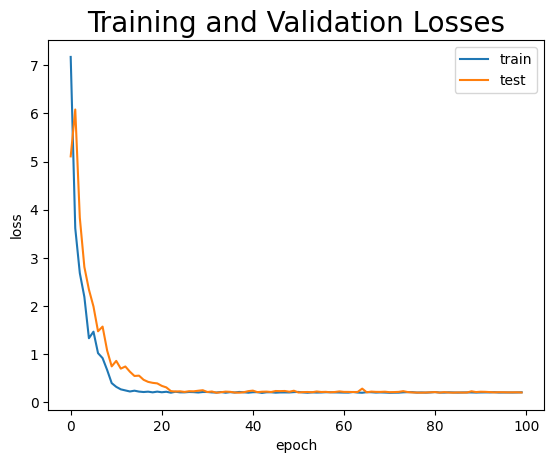

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 20)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
     

In [18]:
# Using the newly trained model compute the embeddings 
# for a number images


sample_size = 5106

X_train_trm = base_model.predict(train_images[:sample_size].reshape(-1,224,224,3))
X_test_trm = base_model.predict(valid_images[:461].reshape(-1,224,224,3))

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)

15/15 [==============================] - 1s 77ms/step


In [28]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-64

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2778903332.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


/tmp/ipykernel_32/1954840028.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


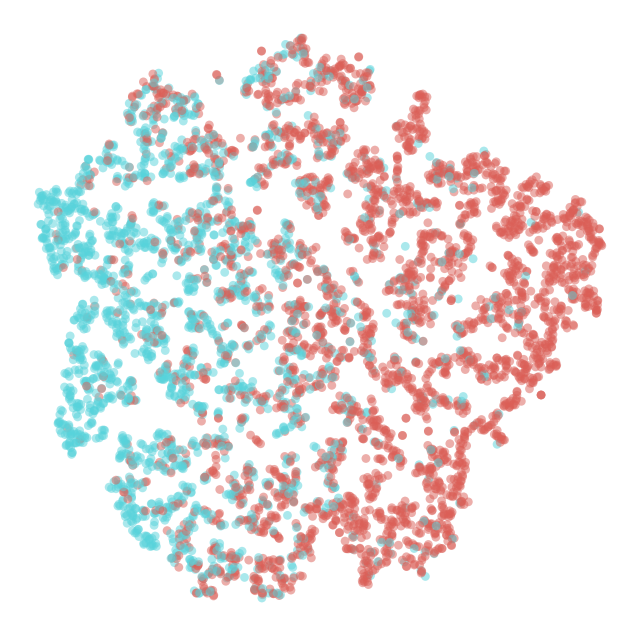

In [23]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/3667496653.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


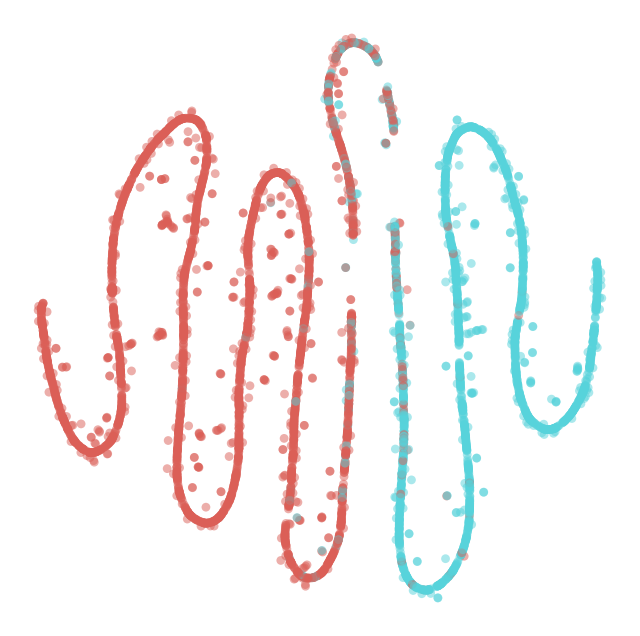

In [41]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-normal-100epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2247794598.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


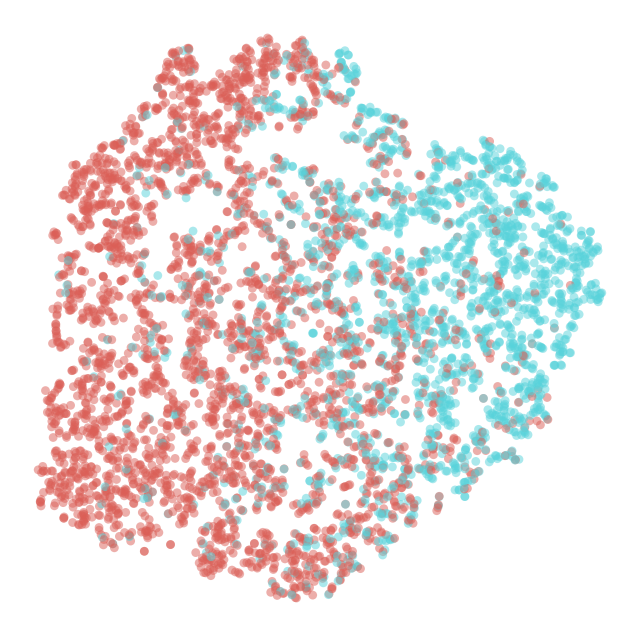

In [33]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-CLAHE

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/295216658.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


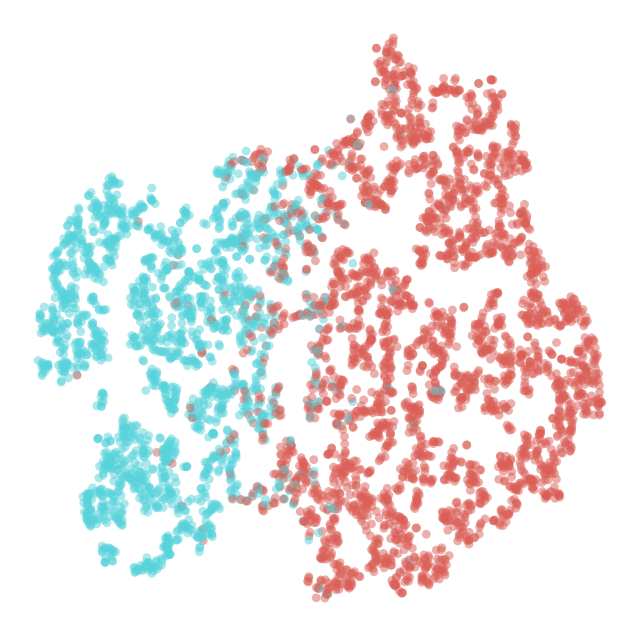

In [33]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-CLAHE-100epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/1452268145.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


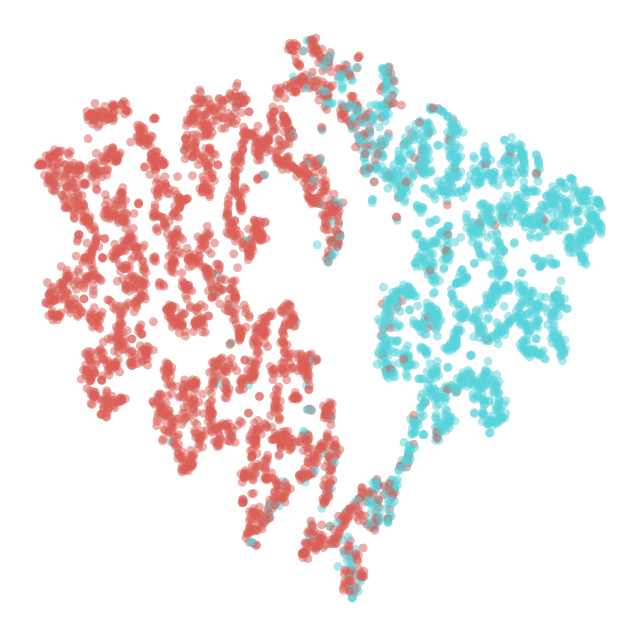

In [24]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-CLAHE-100epochs-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

In [27]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-CLAHE-200epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2381653870.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


/tmp/ipykernel_32/590552000.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


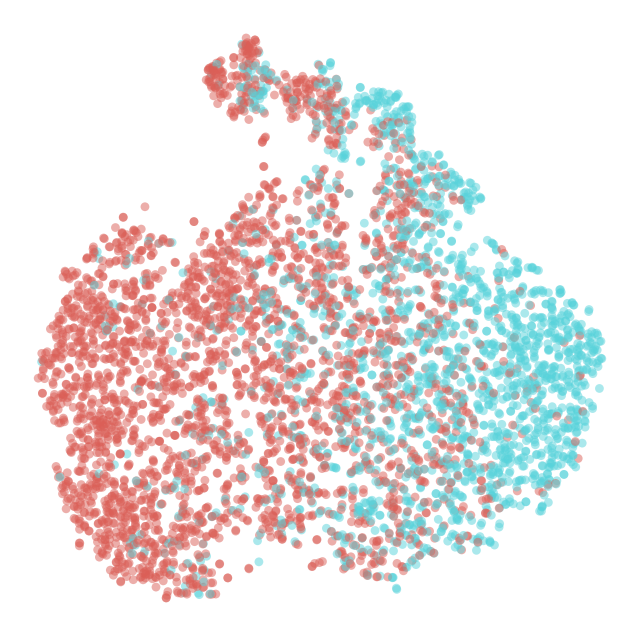

In [20]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-128-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/437106486.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


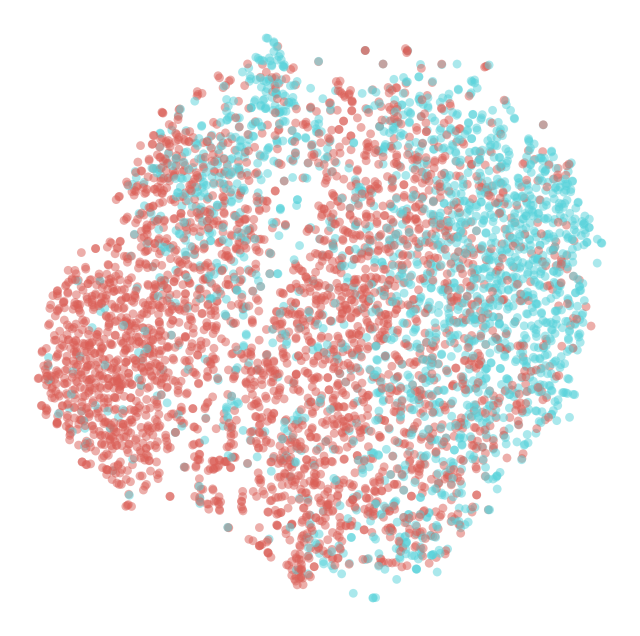

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2083827451.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


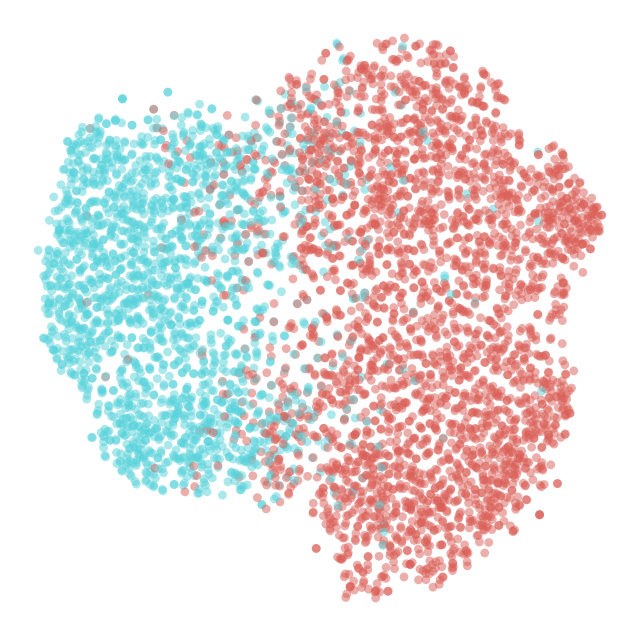

In [20]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-normal-100epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-CLAHE-100 epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2425821259.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-CLAHE

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/1687804233.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


/tmp/ipykernel_32/1128299627.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


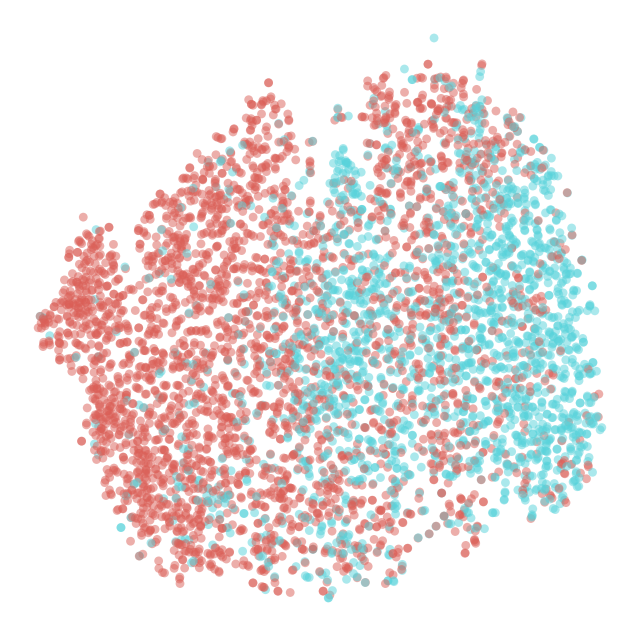

In [66]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/1128299627.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


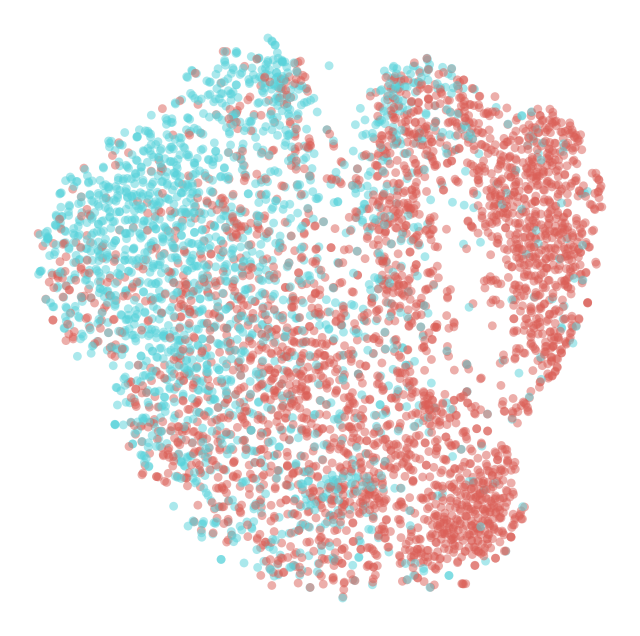

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/1128299627.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


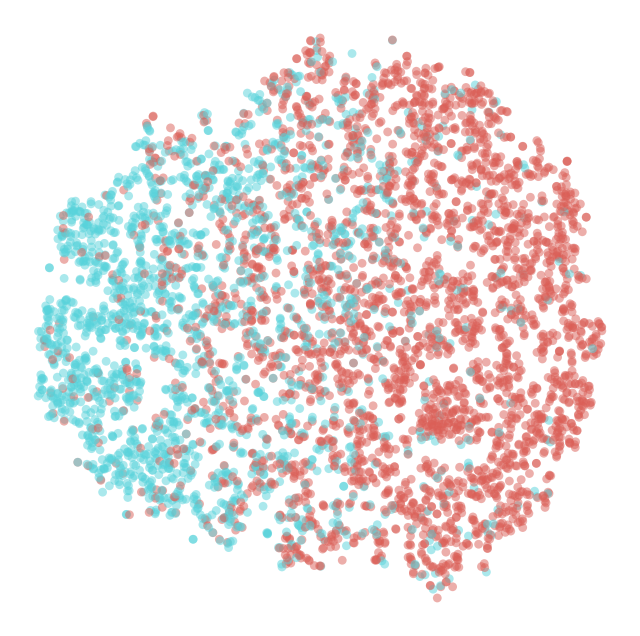

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet50-256-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

In [24]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-256

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/3610923401.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-256-100epochs

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/2819821671.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


/tmp/ipykernel_32/1227764014.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


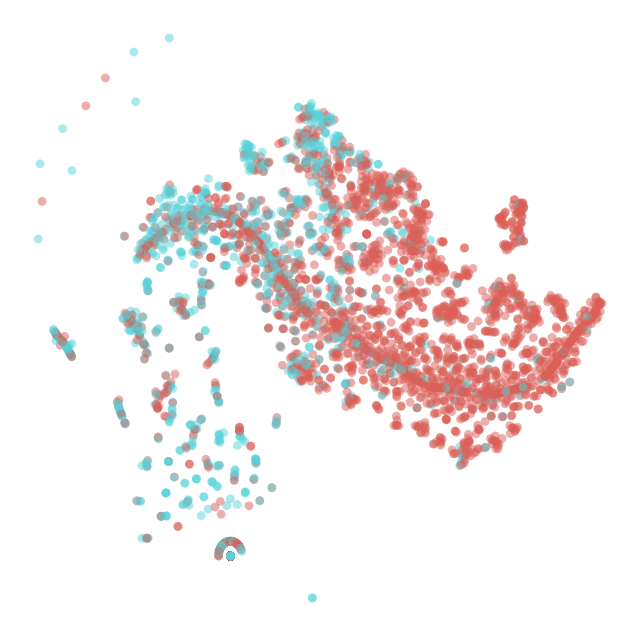

In [30]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-128

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_33/1227764014.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


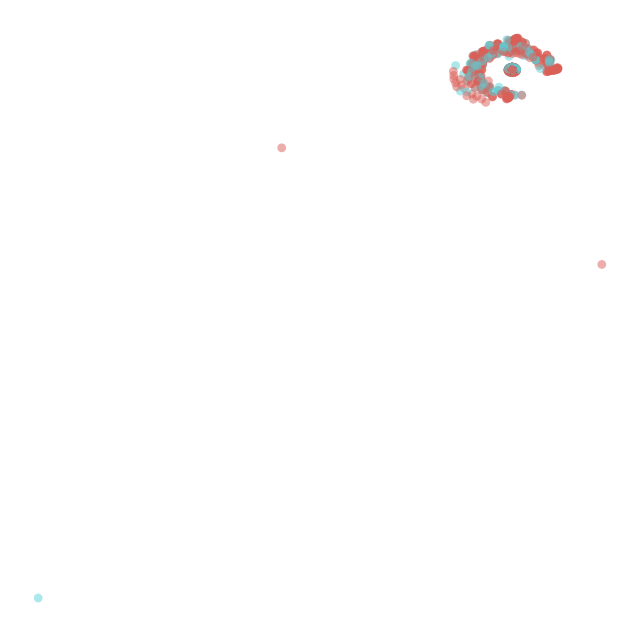

In [23]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-128-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/3155990406.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


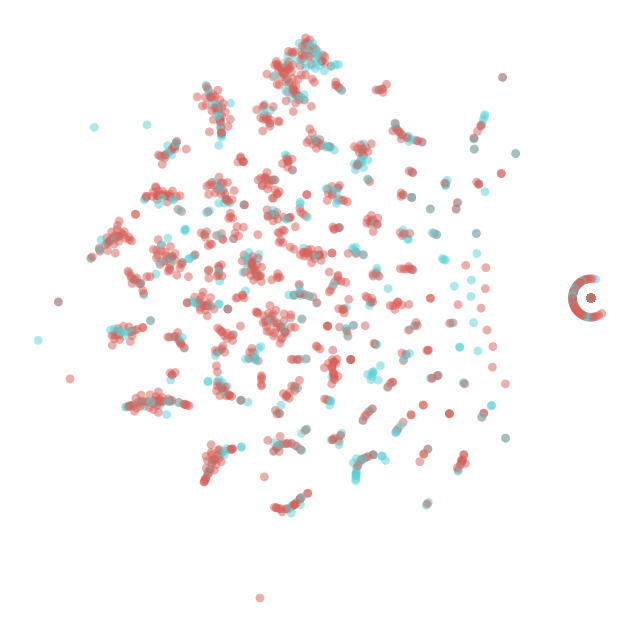

In [18]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-128-3

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/1537832470.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


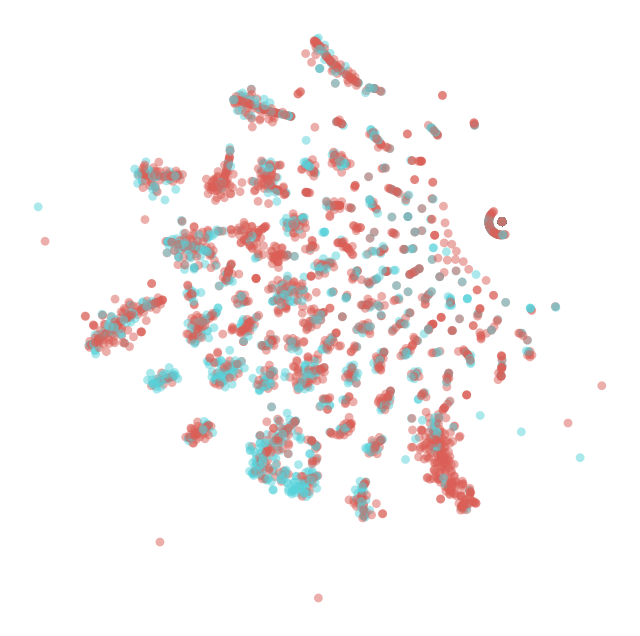

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-128-4

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_33/2789103164.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


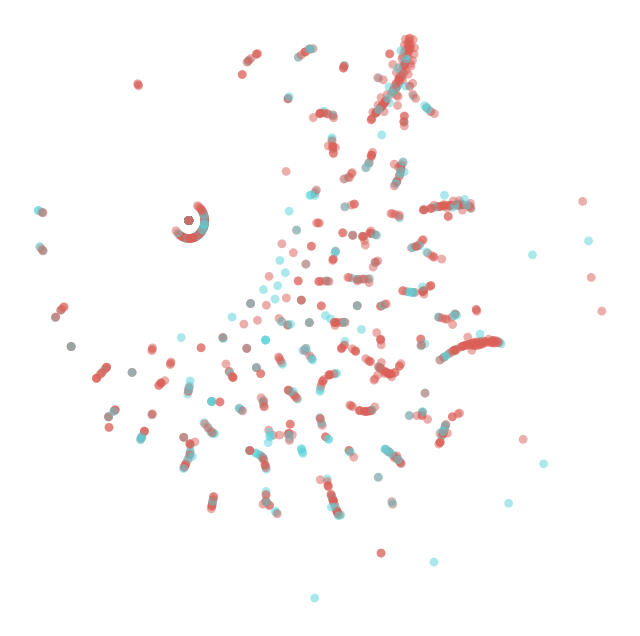

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-64

scatter(train_tsne_embeds, train_image_labels[:sample_size])

In [52]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #resnet50-256

scatter(train_tsne_embeds, train_image_labels[:sample_size])

/tmp/ipykernel_32/3610923401.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


/tmp/ipykernel_990/59706149.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  c=palette[labels.astype(np.int)] )


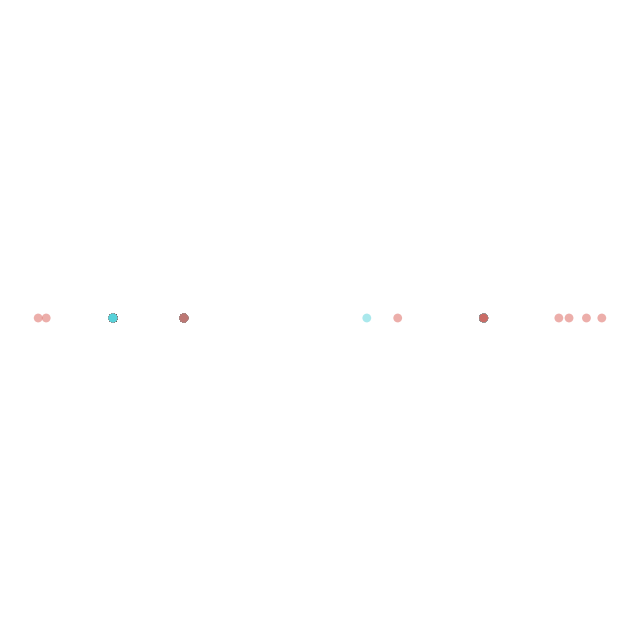

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    
    #densenet169-2

scatter(train_tsne_embeds, train_image_labels[:sample_size])

In [21]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#DenseNet169-128

Epoch 1/50
160/160 [==============================] - 2s 3ms/step - loss: 0.6392 - accuracy: 0.6146 - val_loss: 0.7078 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6118 - accuracy: 0.6175 - val_loss: 0.6809 - val_accuracy: 0.4859
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5908 - accuracy: 0.6439 - val_loss: 0.6809 - val_accuracy: 0.4946
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5722 - accuracy: 0.6774 - val_loss: 0.6645 - val_accuracy: 0.5510
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5556 - accuracy: 0.7244 - val_loss: 0.6589 - val_accuracy: 0.5531
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5406 - accuracy: 0.7489 - val_loss: 0.6385 - val_accuracy: 0.6226
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5277 - accuracy: 0.7722 - val_loss: 0.6361 - val_accuracy: 0.6291
Epoch 

In [21]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-256-normal-100epochs

Epoch 1/300
160/160 [==============================] - 2s 4ms/step - loss: 0.6610 - accuracy: 0.6146 - val_loss: 0.7297 - val_accuracy: 0.4642
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5881 - accuracy: 0.6216 - val_loss: 0.6765 - val_accuracy: 0.5054
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5291 - accuracy: 0.7237 - val_loss: 0.6491 - val_accuracy: 0.6052
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4803 - accuracy: 0.8337 - val_loss: 0.6263 - val_accuracy: 0.6616
Epoch 5/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4404 - accuracy: 0.8770 - val_loss: 0.6021 - val_accuracy: 0.7137
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4076 - accuracy: 0.9019 - val_loss: 0.5971 - val_accuracy: 0.7115
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3805 - accuracy: 0.9101 - val_loss: 0.5885 - val_accuracy: 0.7028

In [28]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=500)

#DenseNet169-128-clahe-200epochs

Epoch 1/500
160/160 [==============================] - 2s 7ms/step - loss: 0.6537 - accuracy: 0.6146 - val_loss: 0.6951 - val_accuracy: 0.4642
Epoch 2/500
160/160 [==============================] - 0s 3ms/step - loss: 0.5801 - accuracy: 0.6383 - val_loss: 0.6754 - val_accuracy: 0.4967
Epoch 3/500
160/160 [==============================] - 0s 3ms/step - loss: 0.5162 - accuracy: 0.7834 - val_loss: 0.6420 - val_accuracy: 0.6182
Epoch 4/500
160/160 [==============================] - 0s 3ms/step - loss: 0.4611 - accuracy: 0.9017 - val_loss: 0.6194 - val_accuracy: 0.6594
Epoch 5/500
160/160 [==============================] - 0s 3ms/step - loss: 0.4146 - accuracy: 0.9387 - val_loss: 0.5952 - val_accuracy: 0.7093
Epoch 6/500
160/160 [==============================] - 0s 3ms/step - loss: 0.3754 - accuracy: 0.9618 - val_loss: 0.5872 - val_accuracy: 0.7072
Epoch 7/500
160/160 [==============================] - 0s 3ms/step - loss: 0.3418 - accuracy: 0.9665 - val_loss: 0.5760 - val_accuracy: 0.7137

In [42]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-128-normal-100epochs

Epoch 1/300
160/160 [==============================] - 1s 4ms/step - loss: 0.6707 - accuracy: 0.7523 - val_loss: 0.6708 - val_accuracy: 0.7440
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6328 - accuracy: 0.9358 - val_loss: 0.6531 - val_accuracy: 0.7462
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5991 - accuracy: 0.9340 - val_loss: 0.6352 - val_accuracy: 0.7440
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5678 - accuracy: 0.9430 - val_loss: 0.6202 - val_accuracy: 0.7440
Epoch 5/300
160/160 [==============================] - 1s 3ms/step - loss: 0.5390 - accuracy: 0.9409 - val_loss: 0.6061 - val_accuracy: 0.7440
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5128 - accuracy: 0.9438 - val_loss: 0.5945 - val_accuracy: 0.7440
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4888 - accuracy: 0.9440 - val_loss: 0.5838 - val_accuracy: 0.7440

In [34]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#DenseNet169-128-CLAHE

Epoch 1/50
160/160 [==============================] - 1s 3ms/step - loss: 0.6603 - accuracy: 0.6146 - val_loss: 0.7227 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6475 - accuracy: 0.6146 - val_loss: 0.7251 - val_accuracy: 0.4642
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6372 - accuracy: 0.6146 - val_loss: 0.7205 - val_accuracy: 0.4642
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6277 - accuracy: 0.6152 - val_loss: 0.7025 - val_accuracy: 0.4642
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6188 - accuracy: 0.6169 - val_loss: 0.7030 - val_accuracy: 0.4685
Epoch 6/50
160/160 [==============================] - 0s 2ms/step - loss: 0.6102 - accuracy: 0.6226 - val_loss: 0.6936 - val_accuracy: 0.4816
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6020 - accuracy: 0.6330 - val_loss: 0.6920 - val_accuracy: 0.4902
Epoch 

In [34]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-128-CLAHE-100epochs

Epoch 1/300
160/160 [==============================] - 1s 4ms/step - loss: 0.6293 - accuracy: 0.7756 - val_loss: 0.6717 - val_accuracy: 0.4859
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5595 - accuracy: 0.7317 - val_loss: 0.6494 - val_accuracy: 0.5770
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5061 - accuracy: 0.8445 - val_loss: 0.6241 - val_accuracy: 0.6681
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4609 - accuracy: 0.8909 - val_loss: 0.6024 - val_accuracy: 0.7007
Epoch 5/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4226 - accuracy: 0.9189 - val_loss: 0.5913 - val_accuracy: 0.7115
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3901 - accuracy: 0.9254 - val_loss: 0.5756 - val_accuracy: 0.7375
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3620 - accuracy: 0.9313 - val_loss: 0.5647 - val_accuracy: 0.7310

In [25]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-128-CLAHE-100epochs-2

Epoch 1/300
160/160 [==============================] - 2s 4ms/step - loss: 0.6037 - accuracy: 0.6246 - val_loss: 0.6821 - val_accuracy: 0.4924
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5501 - accuracy: 0.7076 - val_loss: 0.6618 - val_accuracy: 0.5466
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5057 - accuracy: 0.7899 - val_loss: 0.6445 - val_accuracy: 0.5879
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4679 - accuracy: 0.8525 - val_loss: 0.6244 - val_accuracy: 0.6356
Epoch 5/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4355 - accuracy: 0.8833 - val_loss: 0.6121 - val_accuracy: 0.6508
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4076 - accuracy: 0.9029 - val_loss: 0.5999 - val_accuracy: 0.6681
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3836 - accuracy: 0.9162 - val_loss: 0.5913 - val_accuracy: 0.6833

In [20]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((128,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#ResNet-128

Epoch 1/50
160/160 [==============================] - 2s 3ms/step - loss: 0.6777 - accuracy: 0.6112 - val_loss: 0.7049 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6146 - val_loss: 0.7165 - val_accuracy: 0.4642
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6582 - accuracy: 0.6146 - val_loss: 0.7225 - val_accuracy: 0.4642
Epoch 4/50
160/160 [==============================] - 1s 3ms/step - loss: 0.6557 - accuracy: 0.6146 - val_loss: 0.7250 - val_accuracy: 0.4642
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6540 - accuracy: 0.6146 - val_loss: 0.7236 - val_accuracy: 0.4642
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6526 - accuracy: 0.6150 - val_loss: 0.7238 - val_accuracy: 0.4642
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6511 - accuracy: 0.6152 - val_loss: 0.7228 - val_accuracy: 0.4642
Epoch 

In [54]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#ResNet-256

Epoch 1/50
160/160 [==============================] - 1s 4ms/step - loss: 0.6817 - accuracy: 0.6091 - val_loss: 0.7054 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6682 - accuracy: 0.6146 - val_loss: 0.7167 - val_accuracy: 0.4642
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6632 - accuracy: 0.6146 - val_loss: 0.7219 - val_accuracy: 0.4642
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6148 - val_loss: 0.7249 - val_accuracy: 0.4642
Epoch 5/50
160/160 [==============================] - 1s 3ms/step - loss: 0.6585 - accuracy: 0.6150 - val_loss: 0.7252 - val_accuracy: 0.4642
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6567 - accuracy: 0.6150 - val_loss: 0.7243 - val_accuracy: 0.4642
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6551 - accuracy: 0.6165 - val_loss: 0.7227 - val_accuracy: 0.4685
Epoch 

In [67]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#DenseNet169-256

Epoch 1/50
160/160 [==============================] - 1s 3ms/step - loss: 0.7159 - accuracy: 0.5309 - val_loss: 0.7351 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6634 - accuracy: 0.6146 - val_loss: 0.7179 - val_accuracy: 0.4642
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6446 - accuracy: 0.6146 - val_loss: 0.7044 - val_accuracy: 0.4642
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6263 - accuracy: 0.6161 - val_loss: 0.6953 - val_accuracy: 0.4642
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6086 - accuracy: 0.6314 - val_loss: 0.6978 - val_accuracy: 0.4664
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5936 - accuracy: 0.6569 - val_loss: 0.6680 - val_accuracy: 0.5206
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5796 - accuracy: 0.6913 - val_loss: 0.6680 - val_accuracy: 0.5293
Epoch 

In [20]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-256-CLAHE-300 epochs

Epoch 1/300
160/160 [==============================] - 1s 4ms/step - loss: 0.6406 - accuracy: 0.6177 - val_loss: 0.6720 - val_accuracy: 0.5076
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5757 - accuracy: 0.7139 - val_loss: 0.6334 - val_accuracy: 0.6551
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5238 - accuracy: 0.8353 - val_loss: 0.6150 - val_accuracy: 0.6833
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4810 - accuracy: 0.8694 - val_loss: 0.5870 - val_accuracy: 0.7440
Epoch 5/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4451 - accuracy: 0.8868 - val_loss: 0.5753 - val_accuracy: 0.7462
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4155 - accuracy: 0.8958 - val_loss: 0.5530 - val_accuracy: 0.7614
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3906 - accuracy: 0.9003 - val_loss: 0.5555 - val_accuracy: 0.7505

In [41]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#DenseNet169-256-CLAHE-300 epochs-2

Epoch 1/300
160/160 [==============================] - 1s 4ms/step - loss: 0.6560 - accuracy: 0.5678 - val_loss: 0.6894 - val_accuracy: 0.4664
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5718 - accuracy: 0.6600 - val_loss: 0.6673 - val_accuracy: 0.5228
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.5107 - accuracy: 0.8149 - val_loss: 0.6344 - val_accuracy: 0.6399
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.4590 - accuracy: 0.8794 - val_loss: 0.6039 - val_accuracy: 0.6985
Epoch 5/300
160/160 [==============================] - 0s 2ms/step - loss: 0.4168 - accuracy: 0.9168 - val_loss: 0.5873 - val_accuracy: 0.7158
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3816 - accuracy: 0.9295 - val_loss: 0.5871 - val_accuracy: 0.7050
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.3524 - accuracy: 0.9338 - val_loss: 0.5856 - val_accuracy: 0.7072

In [20]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=50)

#DenseNet169-256-CLAHE

Epoch 1/50
160/160 [==============================] - 2s 3ms/step - loss: 0.6522 - accuracy: 0.6148 - val_loss: 0.7057 - val_accuracy: 0.4642
Epoch 2/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6278 - accuracy: 0.6148 - val_loss: 0.6882 - val_accuracy: 0.4664
Epoch 3/50
160/160 [==============================] - 0s 3ms/step - loss: 0.6074 - accuracy: 0.6251 - val_loss: 0.6803 - val_accuracy: 0.4816
Epoch 4/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5882 - accuracy: 0.6492 - val_loss: 0.6639 - val_accuracy: 0.5228
Epoch 5/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5713 - accuracy: 0.6992 - val_loss: 0.6569 - val_accuracy: 0.5553
Epoch 6/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5558 - accuracy: 0.7288 - val_loss: 0.6427 - val_accuracy: 0.6074
Epoch 7/50
160/160 [==============================] - 0s 3ms/step - loss: 0.5418 - accuracy: 0.7626 - val_loss: 0.6344 - val_accuracy: 0.6269
Epoch 

In [20]:
# Create a Classifier that computes the class of a specific embedding. 
Classifier_input = Input((256,))
Classifier_output = Dense(2, activation='softmax')(Classifier_input)
Classifier_model = Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
Y_train_onehot = np_utils.to_categorical(train_image_labels, 2)[:5106]
Y_test_onehot = np_utils.to_categorical(valid_image_labels, 2)[:461]

Classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
Classifier_model.fit(X_train_trm,Y_train_onehot, validation_data=(X_test_trm,Y_test_onehot),epochs=300)

#resnet50-256-normal-100epochs

Epoch 1/300
160/160 [==============================] - 2s 4ms/step - loss: 0.6808 - accuracy: 0.6146 - val_loss: 0.7061 - val_accuracy: 0.4642
Epoch 2/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.6146 - val_loss: 0.7186 - val_accuracy: 0.4642
Epoch 3/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6644 - accuracy: 0.6146 - val_loss: 0.7266 - val_accuracy: 0.4642
Epoch 4/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6628 - accuracy: 0.6146 - val_loss: 0.7298 - val_accuracy: 0.4642
Epoch 5/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.6146 - val_loss: 0.7318 - val_accuracy: 0.4642
Epoch 6/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6611 - accuracy: 0.6146 - val_loss: 0.7310 - val_accuracy: 0.4642
Epoch 7/300
160/160 [==============================] - 0s 3ms/step - loss: 0.6603 - accuracy: 0.6146 - val_loss: 0.7306 - val_accuracy: 0.4642

In [41]:
Y_train_onehot[0]
train_image_labels[0]

0

In [29]:
Classifier_model.save("MURA-Classifier-128-clahe-Dense-Finger-200epochs.h5")

In [28]:
pred = Classifier_model.predict(base_model.predict(train_images[:sample_size].reshape(-1,224,224,3)))
#pred = Classifier_model.predict(base_model.predict(valid_images[:461].reshape(-1,224,224,3)))

160/160 [==============================] - 0s 1ms/step


In [29]:
pred[222]

array([0.70574886, 0.29425114], dtype=float32)

In [38]:
train_image_labels[222]

0

In [30]:
predictions = []
for p in pred:
    if(p[0] > p[1]):
        predictions+=[0]
    else:
        predictions+=[1]

In [38]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-128-CLAHE

0.19428123775949863


In [40]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-128-CLAHE-100epochs

0.04876615746180964


In [26]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-256-normal-train-100epochs

0.0699177438307873


In [32]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#DenseNet169-256-normal-test-100epochs

0.27765726681127983


In [39]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#DenseNet169-128-clahe-test-200epochs

0.25813449023861174


In [53]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-128-normal-train-100epochs

0.05346650998824912


In [31]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#resnet-256-normal-train-100epochs

0.3644731688209949


In [46]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#DenseNet169-128-normal-test-100epochs

0.2559652928416486


In [29]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#DenseNet169-128-CLAHE-100epochs-test

0.2646420824295011


In [23]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#resnet-256-100epochs-test

0.5032537960954447


In [ ]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-128

In [43]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#ResNet-128

0.3627105366235801


In [58]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#ResNet-256

0.3564433999216608


In [71]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-256

0.2128867998433216


In [25]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-256-CLAHE

0.1735213474343909


In [25]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-256-CLAHE-100epochs

0.06227967097532315


In [34]:
error = np.sum(np.not_equal(predictions, train_image_labels)) / train_image_labels.shape[0]
print(error)
#DenseNet169-128-CLAHE-200epochs-train

0.015667841754798278


In [45]:
error = np.sum(np.not_equal(predictions, valid_image_labels)) / valid_image_labels.shape[0]
print(error)
#DenseNet169-256-CLAHE-100epochs-test

0.24945770065075923


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128

Confusion Matrix:
[[2752  386]
 [ 557 1411]]

Sensitivity: 0.7170
Specificity: 0.8770


In [39]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-CLAHE

Confusion Matrix:
[[2894  244]
 [ 748 1220]]

Sensitivity: 0.6199
Specificity: 0.9222


In [41]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-CLAHE-100epochs

Confusion Matrix:
[[3025  113]
 [ 136 1832]]

Sensitivity: 0.9309
Specificity: 0.9640


In [35]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-CLAHE-200epochs-train

Confusion Matrix:
[[3101   37]
 [  43 1925]]

Sensitivity: 0.9782
Specificity: 0.9882


In [30]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = valid_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-CLAHE-100epochs-test

Confusion Matrix:
[[178  36]
 [ 86 161]]

Sensitivity: 0.6518
Specificity: 0.8318


In [40]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = valid_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-CLAHE-200epochs-test

Confusion Matrix:
[[182  32]
 [ 87 160]]

Sensitivity: 0.6478
Specificity: 0.8505


In [46]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = valid_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256-CLAHE-100epochs-test

Confusion Matrix:
[[177  37]
 [ 78 169]]

Sensitivity: 0.6842
Specificity: 0.8271


In [33]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = valid_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256-normal-100epochs-test

Confusion Matrix:
[[171  43]
 [ 85 162]]

Sensitivity: 0.6559
Specificity: 0.7991


In [47]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = valid_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-128-normal-100epochs-test

Confusion Matrix:
[[174  40]
 [ 78 169]]

Sensitivity: 0.6842
Specificity: 0.8131


In [28]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256-normal-100epochs-train

Confusion Matrix:
[[2990  148]
 [ 209 1759]]

Sensitivity: 0.8938
Specificity: 0.9528


In [44]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#ResNet-128

Confusion Matrix:
[[3033  105]
 [1747  221]]

Sensitivity: 0.1123
Specificity: 0.9665


In [32]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#ResNet-256-100epochs

Confusion Matrix:
[[3060   78]
 [1783  185]]

Sensitivity: 0.0940
Specificity: 0.9751


In [59]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#ResNet-256

Confusion Matrix:
[[2982  156]
 [1664  304]]

Sensitivity: 0.1545
Specificity: 0.9503


In [72]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256

Confusion Matrix:
[[2623  515]
 [ 572 1396]]

Sensitivity: 0.7093
Specificity: 0.8359


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256-CLAHE

Confusion Matrix:
[[2768  370]
 [ 516 1452]]

Sensitivity: 0.7378
Specificity: 0.8821


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

# Assuming you have a trained CNN model called '
# Assuming you have test data and corresponding

# Make predictions on test data
y_pred = predictions


y_test_classes = train_image_labels

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred)

# Extract true positives, false negatives, true
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity (recall) and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)


# Print confusion matrix
print("Confusion Matrix:")
print(cm)

print("\nSensitivity: {:.4f}".format(sensitivity))
print("Specificity: {:.4f}".format(specificity))

#DenseNet169-256-CLAHE-100epochs

Confusion Matrix:
[[2984  154]
 [ 164 1804]]

Sensitivity: 0.9167
Specificity: 0.9509


In [48]:
#DenseNet169-128
cohen_kappa_score(train_image_labels, predictions)


0.603742970388355

In [40]:
#DenseNet169-128-CLAHE
cohen_kappa_score(train_image_labels, predictions)


0.5693442870493938

In [42]:
#DenseNet169-128-CLAHE-100epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.8968380895628767

In [31]:
#DenseNet169-128-CLAHE-100epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.47616563902911535

In [45]:
#ResNet-128
cohen_kappa_score(train_image_labels, predictions)

0.09335698811163307

In [60]:
#ResNet-256
cohen_kappa_score(train_image_labels, predictions)

0.12221700818603687

In [73]:
#DenseNet169-256
cohen_kappa_score(train_image_labels, predictions)


0.548192279720799

In [27]:
#DenseNet169-256-CLAHE
cohen_kappa_score(train_image_labels, predictions)


0.6285889368678137

In [29]:
#DenseNet169-256-normal-100epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.8515576559158383

In [54]:
#DenseNet169-128-normal-100epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.88715188978799

In [36]:
#DenseNet169-128-normal-200epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.966909016320932

In [49]:
#DenseNet169-128-normal-100epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.49146489670000937

In [26]:
from sklearn.metrics import cohen_kappa_score


In [27]:
#resnet-256-normal-100epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.05332105934003695

In [41]:
#DenseNet169-128-clahe-200epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.489830839478848

In [34]:
#DenseNet169-256-normal-100epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.4490485705215589

In [27]:
#DenseNet169-256-CLAHE-100epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.8684134518603233

In [33]:
#resnet-256-100epochs-train
cohen_kappa_score(train_image_labels, predictions)


0.08246676087003124

In [48]:
#DenseNet169-256-CLAHE-100epochs-test
cohen_kappa_score(valid_image_labels, predictions)


0.5048520113198031

In [32]:
from tensorflow.keras.models import load_model
loaded_model = load_model('/kaggle/input/d/suryaregalla/densenet-128/MURA-Classifier-128-CLAHE-Finger-100epochs.h5')

In [34]:


# Load the model, providing the custom_objects parameter
dense_model = load_model('/kaggle/input/d/suryaregalla/densenet-128/MURA-DenseNET_BASE-128-CLAHE-Finger-100epochs.h5', custom_objects={'identity_loss': identity_loss})


In [35]:
pred = loaded_model.predict(dense_model.predict(train_images[:5106].reshape(-1,224,224,3)))

160/160 [==============================] - 0s 1ms/step
